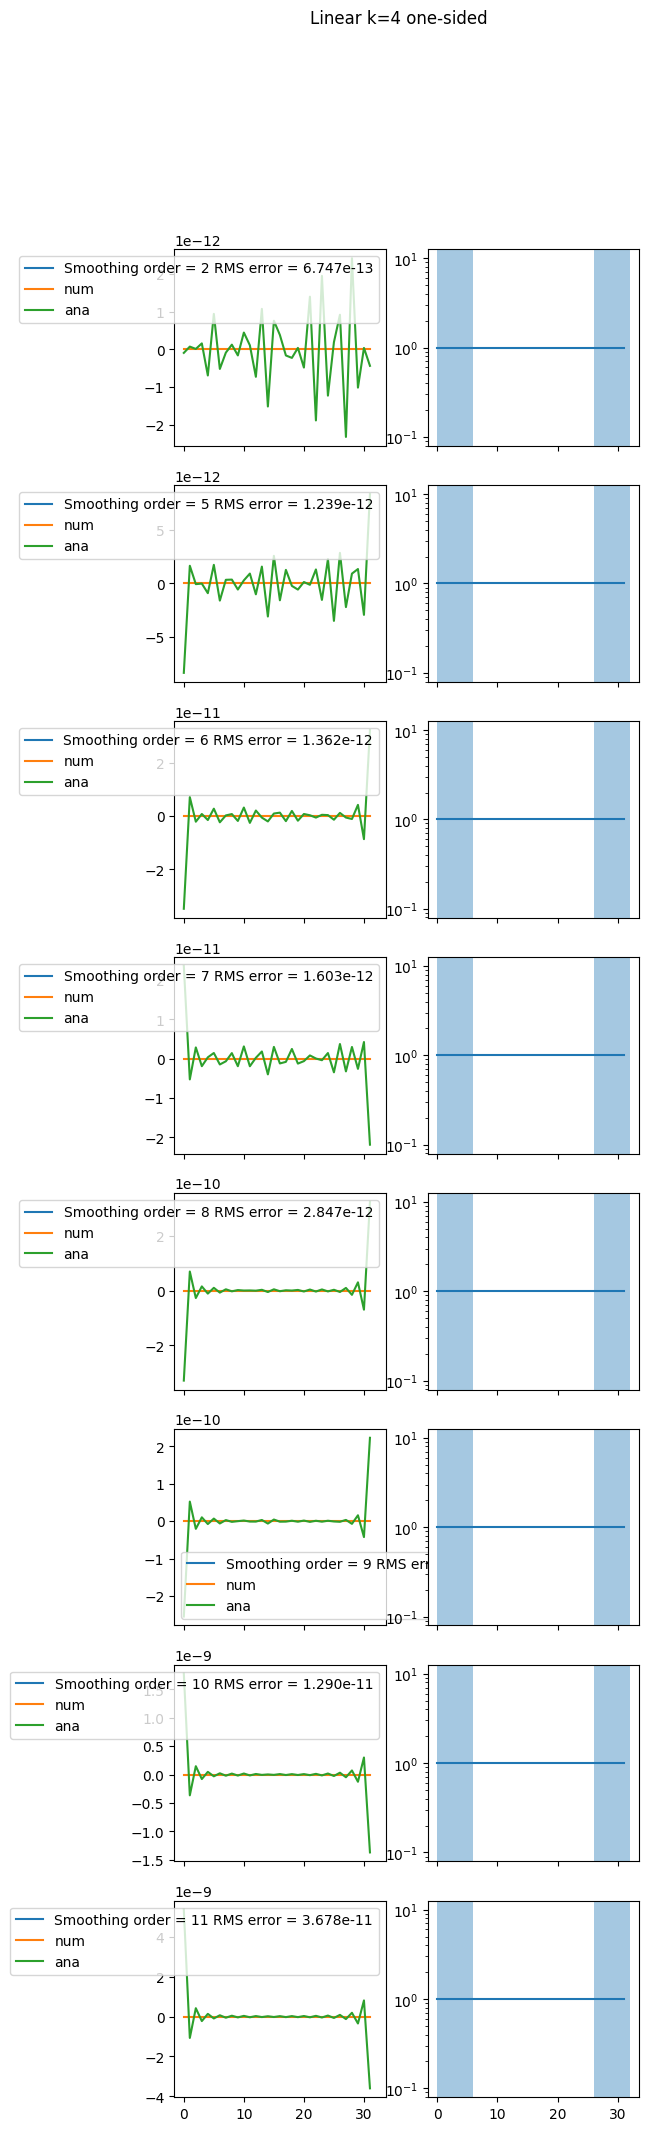

In [7]:
import spectral_derivative as sd
import numpy as np 
import matplotlib.pyplot as plt

L                 = 1
N                 = 32
dx                = L/(N - 1)
x                 = np.arange(0, N) * dx
ghostBoundary     = 6
fdl               = 0
fdr               = 0
BC                = sd.PERIODIC
mode              = sd.M_POLYNOMIAL
derivativeMode    = sd.ONE_SIDED

name = "Linear k=4 one-sided"
k = 4
def func(x):
    return x * k

def ddfunc(x):
    return np.zeros(x.shape)

f      =   func(x)
ddfnum = ddfunc(x)

orders = [2, 5, 6, 7, 8, 9, 10, 11]

fig, axs = plt.subplots(nrows=len(orders), ncols=2, sharex=True, figsize=(6, len(orders) * 3)) 
fig.suptitle(name)
for i, smoothingOrder in enumerate(orders):
    #Create shift function that such that f - B fulfills either Dirichlet, Neumann or periodic boundary conditions depending on mode
    B, poly = sd.getShiftFunction(x, f, mode, derivativeMode, lb = fdl, rb = fdr, N = smoothingOrder, debug=False)
    #Boundary for finite difference stencil
    lind =          fdl
    rind = len(x) - fdr 

    #Subtract linear shift function to enforce Dirichlet BC when computing second derivative
    homf            = f[ lind : rind ] - B[0]
    homf            = np.pad(homf, (0, 1), mode="constant")

    p, ind1, ind2   = sd.selectBC       (homf, BC)
    ddf, k          = sd.laplacianDtt1D (p, dx, BC, debug= False)
    ddfana          = ddf.real + B[1]


    axs[i, 0].plot([], label= f"Smoothing order = {smoothingOrder} RMS error = {np.mean(np.abs(ddfnum - ddfana)[ghostBoundary:-ghostBoundary]):3.3e}")
    axs[i, 0].plot(ddfnum, label="num")
    axs[i, 0].plot(ddfana, label="ana")
    axs[i, 0].legend()
    axs[i, 1].set_yscale("log")
    axs[i, 1].plot(np.abs((ddfnum-ddfana)/ddfana), label="num")
    axs[i, 1].axvspan(0, ghostBoundary, alpha=0.4)
    axs[i, 1].axvspan(len(ddfnum) - ghostBoundary, len(ddfnum), alpha=0.4)
plt.savefig(f"../SpectralDerivative/{name}.png")
plt.show()

The higher the resolution the lower the stencil order should be in order for the whole thing to remain stable. 

## Complex absorbing potential

In [9]:

def absorbingPotential(x, L0_phys, L0_buf, L1_phys, L1_buf):
    y = np.zeros(x.shape)

    delta = L1_buf - L1_phys
    
    y[x <= L0_phys] = np.cos( np.pi * (x[x <= L0_phys] - L0_buf) / ( 2 * delta ) )**2
    y[x >= L1_phys] = np.cos( np.pi * (x[x >= L1_phys] - L1_buf) / ( 2 * delta ) )**2
    return y


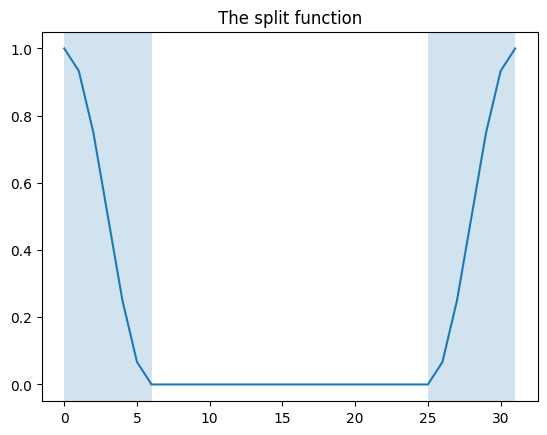

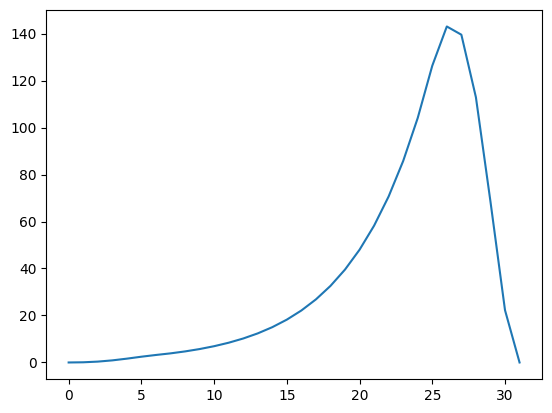

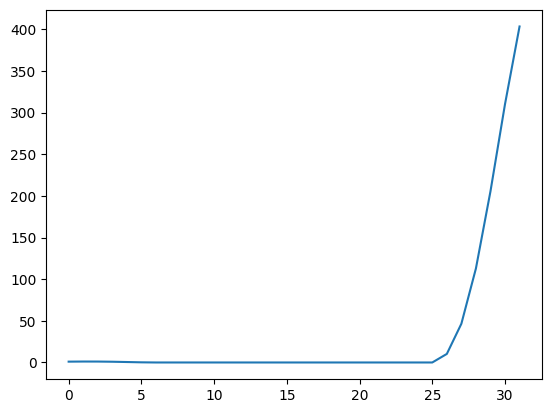

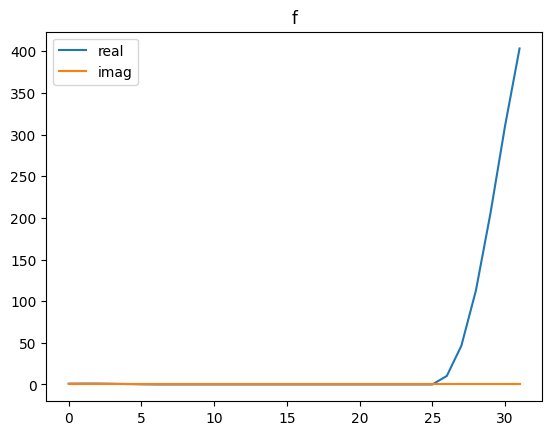

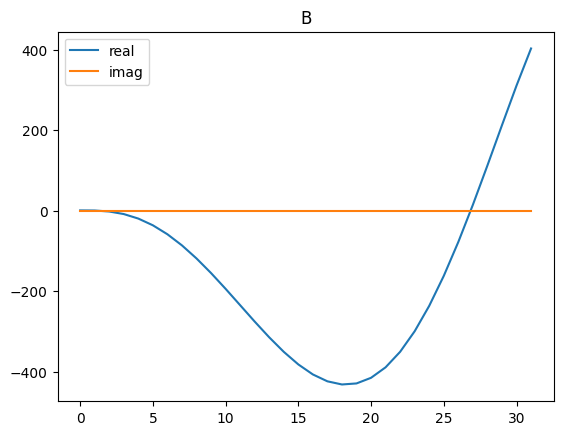

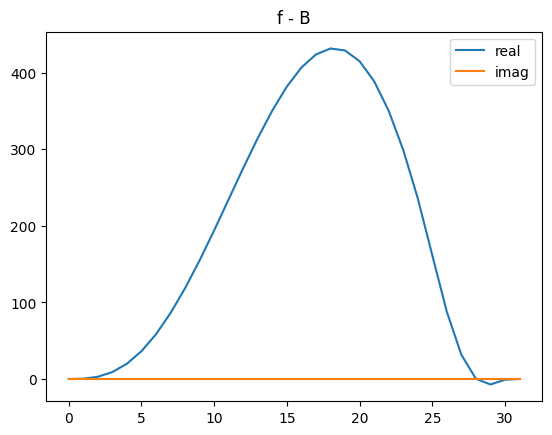

f[lb] = 1.0 f[rb] = 403.4287934927351 B[0][lb] = 1.0  B[0][rb] = 403.4287934927351 homf[lb] = 0.0 homf[rb] = 0.0


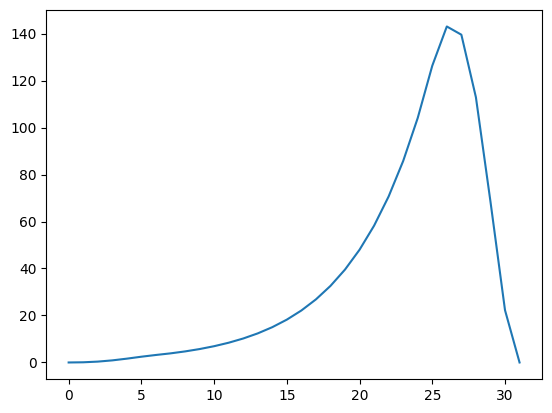

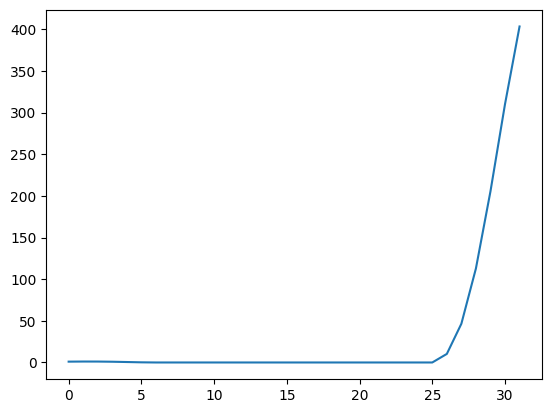

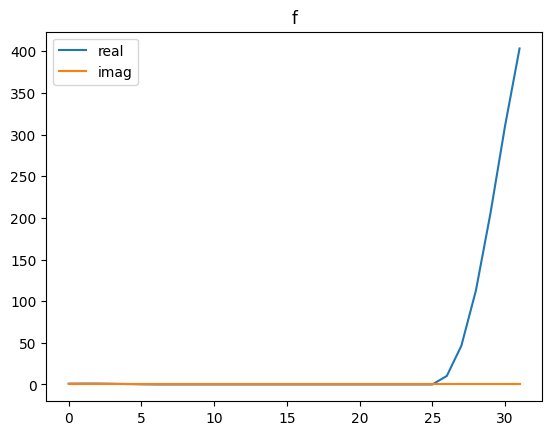

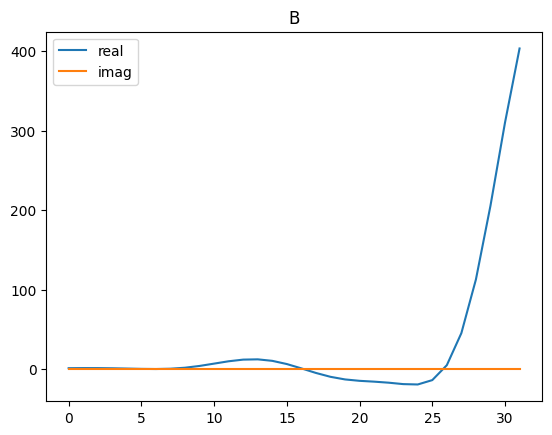

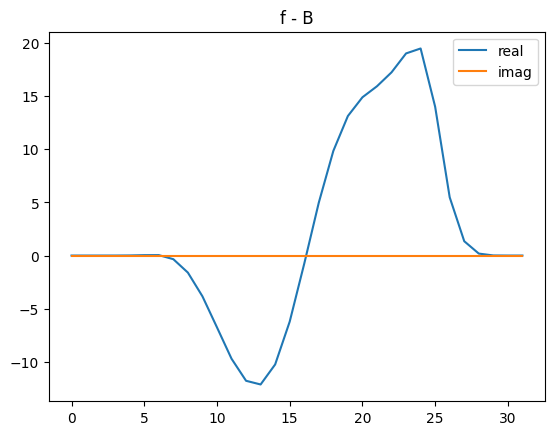

f[lb] = 1.0 f[rb] = 403.4287934927351 B[0][lb] = 1.0000000000002776  B[0][rb] = 403.4287934927351 homf[lb] = -2.7755575615628914e-13 homf[rb] = 0.0


<Figure size 640x480 with 0 Axes>

In [10]:
import spectral_derivative as sd
import numpy as np 
import matplotlib.pyplot as plt

L                 = 1
N                 = 32
dx                = L/(N - 1)
x                 = np.arange(0, N) * dx
ghostBoundary     = 6
fdl               = 0
fdr               = 0
BC                = sd.PERIODIC
mode              = sd.M_POLYNOMIAL
derivativeMode    = sd.ONE_SIDED

name = "Exp k=4 one-sided with kappa splitting"
k = 6
def func(x):
    return np.exp(x*k) 

def ddfunc(x):
    return k**2*np.exp(x*k)

f      =   func(x)
ddfnum = ddfunc(x)

orders = [2, 7]


plt.title("The split function")
size = 6
V = absorbingPotential(x, size * dx, 0, x[-1] - size * dx, L)
plt.plot(V)
plt.axvspan(0, ghostBoundary, alpha=0.2)
plt.axvspan(len(x) - ghostBoundary - 1, len(x) - 1, alpha = 0.2)
plt.show()

#fig, axs = plt.subplots(nrows=len(orders), ncols=2, sharex=True, figsize=(6, len(orders) * 3)) 
#fig.suptitle(name)
for i, smoothingOrder in enumerate(orders):
    phi, kappa = (1-V) * f, V * f

    plt.plot(phi)
    plt.show()
    plt.plot(kappa)
    plt.show()
    #Create shift function that such that f - B fulfills either Dirichlet, Neumann or periodic boundary conditions depending on mode
    B, poly = sd.getShiftFunction(x, kappa, mode, derivativeMode, lb = fdl, rb = fdr, N = smoothingOrder, debug=True)

    #Boundary for finite difference stencil
    lind =          fdl
    rind = len(x) - fdr 

    #Subtract linear shift function to enforce Dirichlet BC when computing second derivative
    homkap          = kappa[ lind : rind ] - B[0]

    homkap          = np.pad(homkap, (0, 1), mode="constant")
    p, ind1, ind2   = sd.selectBC       (homkap, BC)
    ddkap, k        = sd.laplacianDtt1D (p, dx, BC, debug= False)


    homphi          = np.pad(phi, (0, 1), mode="constant")
    p, ind1, ind2   = sd.selectBC       (homphi, BC)
    ddphi, k        = sd.laplacianDtt1D (p, dx, BC, debug= False)

    ddfana          = ddkap.real + B[1] + ddphi.real


    axs[i, 0].plot([], label= f"Smoothing order = {smoothingOrder} RMS error = {np.mean(np.abs(ddfnum - ddfana)[ghostBoundary:-ghostBoundary]):3.3e}")
    axs[i, 0].plot(ddfnum, label="num")
    axs[i, 0].plot(ddfana, label="ana")
    axs[i, 0].legend()
    axs[i, 1].set_yscale("log")
    axs[i, 1].plot(np.abs((ddfnum-ddfana)/ddfana), label="num")
    axs[i, 1].axvspan(0, ghostBoundary, alpha=0.4)
    axs[i, 1].axvspan(len(ddfnum) - ghostBoundary, len(ddfnum), alpha=0.4)
plt.savefig(f"../SpectralDerivative/{name}.png")
plt.show()

## Antisymmetric extension

([(2, 124.07789791579785), (4, 15105.277891048614), (6, 2318599.6463500354)], [(2, 6767.0502488338), (4, 828347.2956649013), (6, 85958672.50921705)])


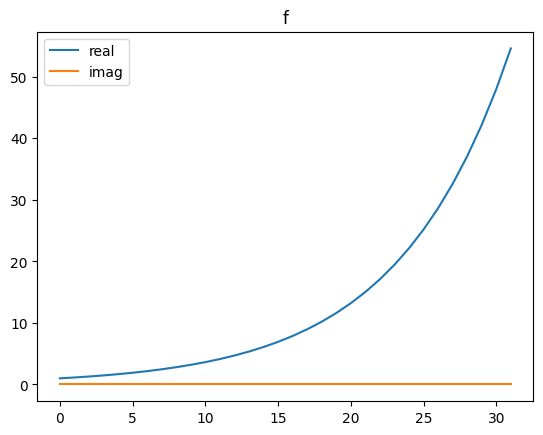

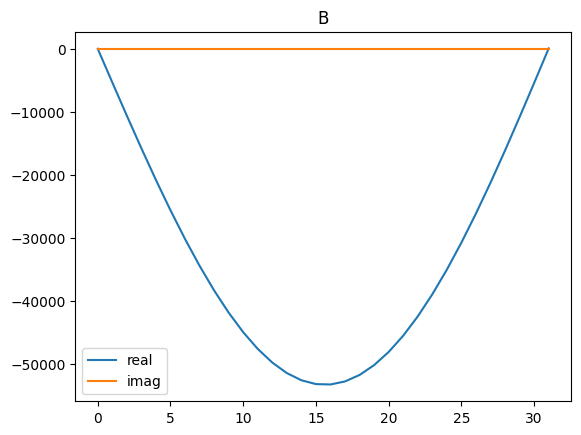

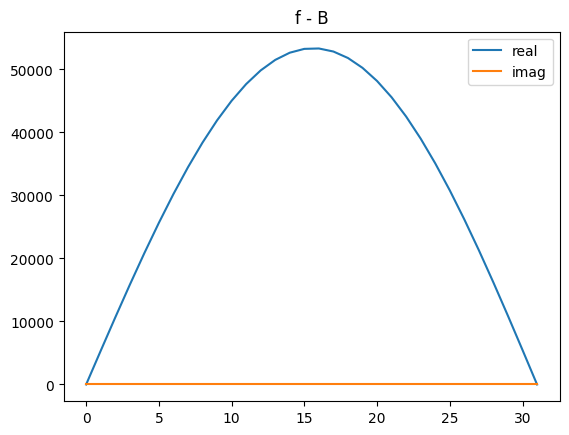

f[lb] = 1.0 f[rb] = 54.598150033144236 B[0][lb] = 1.0000000000946105  B[0][rb] = 54.598150033144236 homf[lb] = -9.461054162329674e-11 homf[rb] = 0.0
[-9.46105416e-11  5.34017790e+03  1.06271065e+04  1.58081304e+04
  2.08315656e+04  2.56471817e+04  3.02066728e+04  3.44641129e+04
  3.83763948e+04  4.19036464e+04  4.50096250e+04  4.76620828e+04
  4.98331044e+04  5.14994094e+04  5.26426205e+04  5.32494915e+04
  5.33120938e+04  5.28279574e+04  5.18001640e+04  5.02373885e+04
  4.81538868e+04  4.55694257e+04  4.25091530e+04  3.90034039e+04
  3.50874412e+04  3.08011261e+04  2.61885163e+04  2.12973889e+04
  1.61786847e+04  1.08858711e+04  5.47422035e+03  0.00000000e+00]


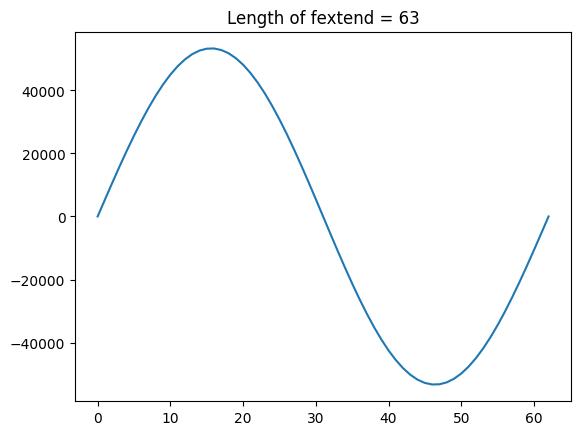

[-9.46105416e-11  5.34017790e+03  1.06271065e+04  1.58081304e+04
  2.08315656e+04  2.56471817e+04  3.02066728e+04  3.44641129e+04
  3.83763948e+04  4.19036464e+04  4.50096250e+04  4.76620828e+04
  4.98331044e+04  5.14994094e+04  5.26426205e+04  5.32494915e+04
  5.33120938e+04  5.28279574e+04  5.18001640e+04  5.02373885e+04
  4.81538868e+04  4.55694257e+04  4.25091530e+04  3.90034039e+04
  3.50874412e+04  3.08011261e+04  2.61885163e+04  2.12973889e+04
  1.61786847e+04  1.08858711e+04  5.47422035e+03  0.00000000e+00
 -5.47422035e+03 -1.08858711e+04 -1.61786847e+04 -2.12973889e+04
 -2.61885163e+04 -3.08011261e+04 -3.50874412e+04 -3.90034039e+04
 -4.25091530e+04 -4.55694257e+04 -4.81538868e+04 -5.02373885e+04
 -5.18001640e+04 -5.28279574e+04 -5.33120938e+04 -5.32494915e+04
 -5.26426205e+04 -5.14994094e+04 -4.98331044e+04 -4.76620828e+04
 -4.50096250e+04 -4.19036464e+04 -3.83763948e+04 -3.44641129e+04
 -3.02066728e+04 -2.56471817e+04 -2.08315656e+04 -1.58081304e+04
 -1.06271065e+04 -5.34017

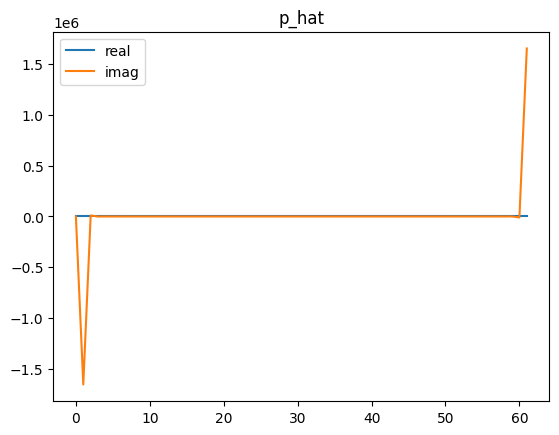

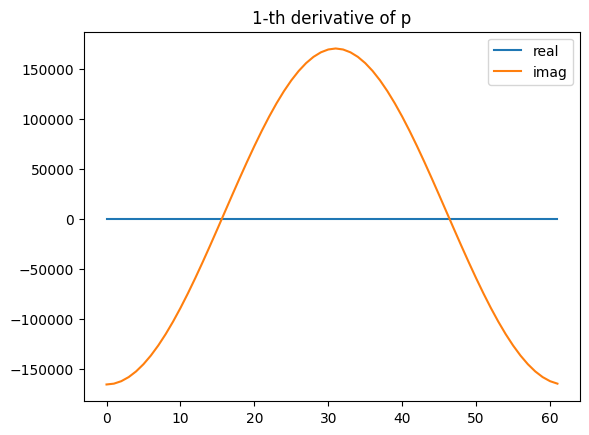

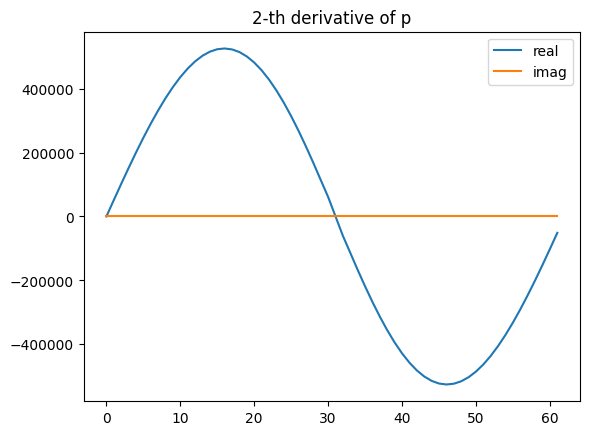

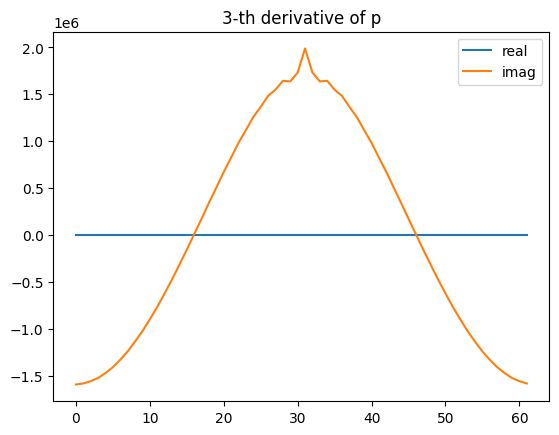

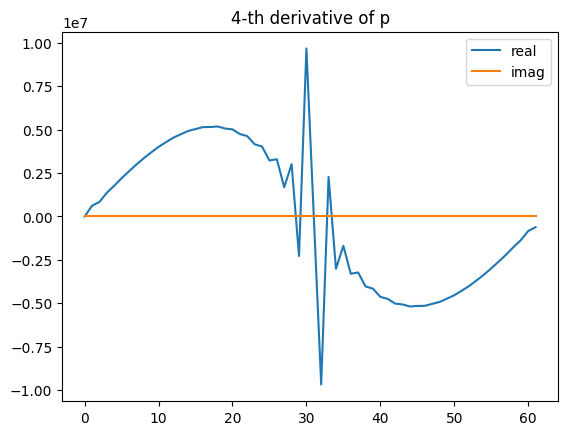

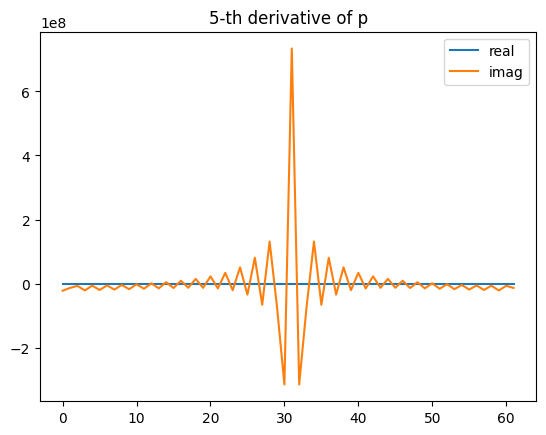

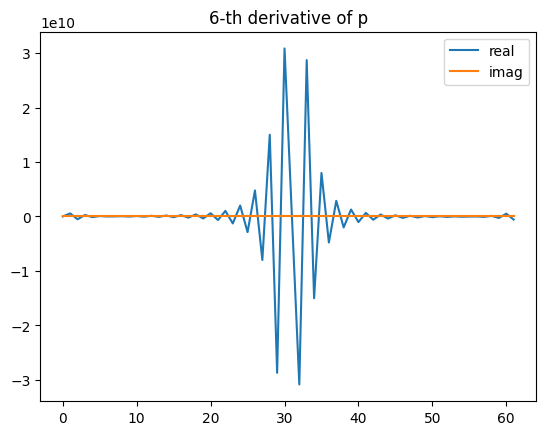

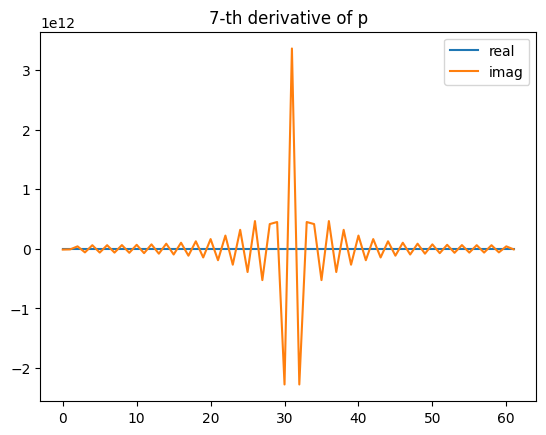

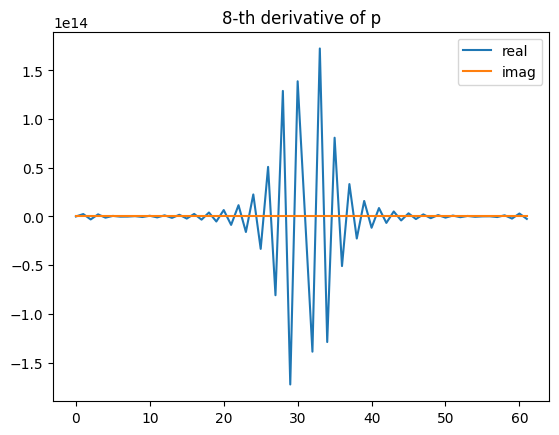

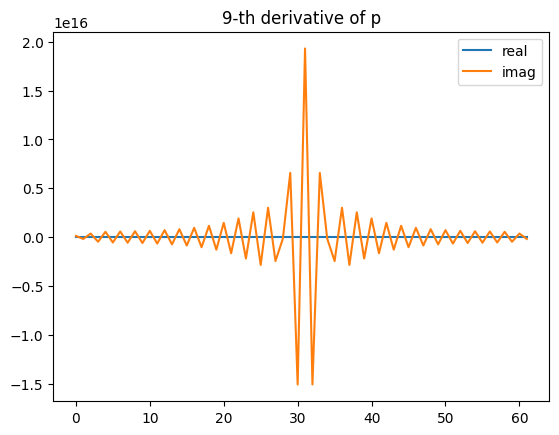

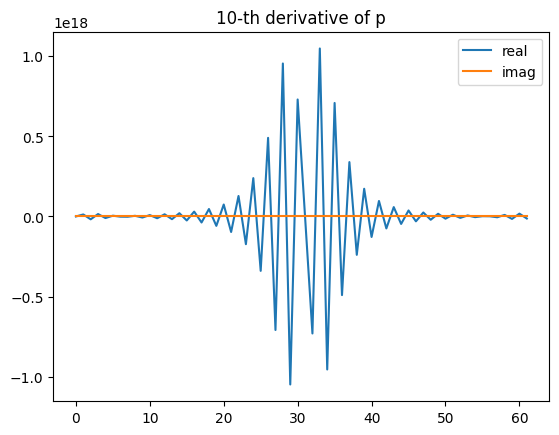

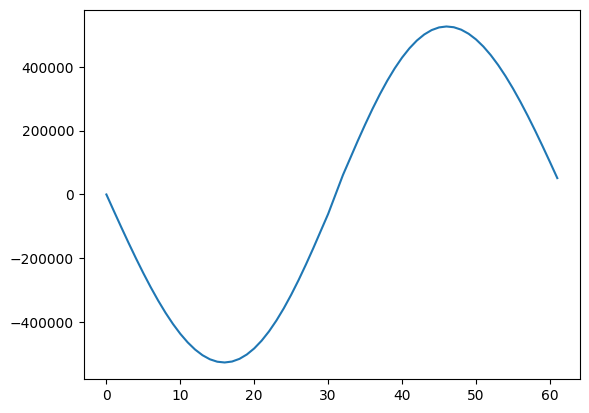

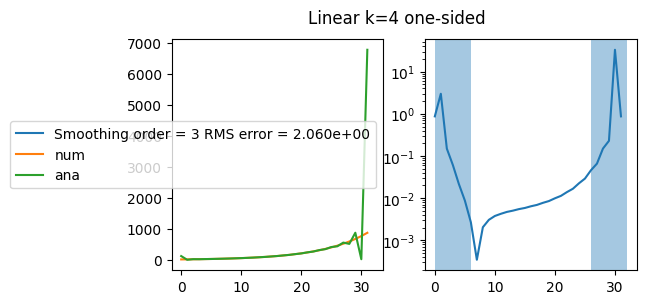